# Problem

We are given an $a \times b$ grid. Each node labeled as $(i, j) \in [1, a]\times [1, b]$

- $S_0$ is a set of nodes that are burning.
- $d_{i, j}$ if node $(i, j)$ is defended.
- $M$ is an $ab \times ab$ probability matrix. $M_{(i, j), (k, l)}$ is the probability that node $(i, j)$ ignites $(k, l)$ - given that node $(i, j)$ is burning.
- $P_{i, j}$ is an integer between $0$ and $R_m$ indicating the risk that node $(i, j)$ burns. Can be computed using $M$ and $S_0$. For a burning node $(i, j) \in S_0$ $P_{i, j} = 1$
- $W$ is the maxomum node that can be saved in a given time window


The expected amount of burning nodes are:
$$\mathbb{E}_t = \sum_{(i, j)}{P_{(i, j)}}$$

We define a set of expected nodes to be burned.
$$S = \{ \lceil \mathbb{E}_t \rceil + 1 \text{ nodes with highest probability of burning }\} \subset \text{ grid }$$




We want to minimize the cost function:

$$C = \sum_{(k, l)}\sum_{(i, j)} M_{(i, j), (k, l)} \mathbb{I}_{\{ (i, k) \in S \}} \mathbb{I}_{\{(k, l) \not\in S\}} (1 - d_{i, j})(1 - d_{k, l})$$


Subject to:
$$\sum_{i, j} d_{i, j} \leq W$$
$$d_{i, j}P_{i, j} \leq R_p - 1$$


This problem is easily translated to QUBO:

$$Q = \sum_{(k, l)}\sum_{(i, j)} M_{(i, j), (k, l)} \mathbb{I}_{\{ (i, k) \in S \}} \mathbb{I}_{\{(k, l) \not\in S\}} (1 - d_{i, j})(1 - d_{k, l})$$
$$P_1 = \alpha \left( \sum_{i, j} d_{i, j} - \left(W - 2^{\lfloor \log _2(W) \rfloor} \right)A_{i, j}^{\lfloor \log _2(W) \rfloor + 1} - \sum_{k = 0}^{\lfloor \log _2(W) \rfloor} 2^{k}A_{i, j}^{k} \right)$$
$$P_2 = \beta \left( \sum_{i, j} P_{i, j}d_{i, j} - \left(R_m - 1 - 2^{\lfloor \log _2(R_m - 1) \rfloor} \right)A_{i, j}^{\lfloor \log _2(R_m - 1) \rfloor + 1} - \sum_{k = 0}^{\lfloor \log _2(R_m - 1) \rfloor} 2^{k}A_{i, j}^{k} \right)$$
$$P_{(i, j)} = 1 - \prod_{(k, l)}\left( 1 - M_{(k, l), (i, j)} \mathbb{I}_{(k, l) \in S_0}\right)$$


In [30]:
from docplex.mp.model import Model
from qiskit.primitives import StatevectorSampler
from qiskit_optimization.algorithms import GroverOptimizer, MinimumEigenOptimizer
from qiskit_optimization.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_optimization.translators import from_docplex_mp
import numpy as np

# Define graph: 2x2 grid
rows = 2
columns = 3
W = 1
max_prob = 6
delta = 1
V = [(i, j) for i in range(rows) for j in range(columns)]

def neighbors(x):
    i, j = x
    return [(ni, nj) for (ni, nj) in V if abs(ni - i) + abs(nj - j) == 1]

T = 1

M = np.random.rand(rows, columns, rows, columns)
# Create arrays of indices
I, J = np.meshgrid(np.arange(rows), np.arange(columns), indexing='ij')

# Set the diagonal entries to 1
M[I, J, I, J] = 1.0


P_new = np.zeros((rows, columns))
S_0 = [(0, 0)]
for i in range(rows):
    for j in range(columns):
        prod = 1.0
        for (k, l) in S_0:
            prod *= 1 - M[k, l, i, j]   # multiply (1 - probability from burning node)
        P_new[i, j] = 1 - prod

# Scale and convert to integers
P_risk = np.round(P_new * max_prob).astype(int)

# Optional: clip in case of rounding issues
P_risk = np.clip(P_risk, 0, max_prob)

P = np.random.randint(1, max_prob, size=(rows, columns))
P[0, 0] = max_prob
E_t = np.sum(P/max_prob)


# Pair each vertex with its probability
pairs = [(x, P[x[0], x[1]]) for x in V]

# Sort by probability descending
pairs_sorted = sorted(pairs, key=lambda y: y[1], reverse=True)

# Take the top E_t + 1 vertices
S = [x for x, prob in pairs_sorted[:int(E_t) + 1]]


# Convert S to a set for fast membership checks
S_set = set(S)

n, m, _, _ = M.shape

# Build boolean masks for the grid
mask_S = np.zeros((n, m), dtype=bool)
for (i, j) in S_set:
    mask_S[i, j] = True

# Expand masks to align with M
mask_ij = mask_S[:, :, None, None]         # True if (i,j) in S
mask_kl = ~mask_S[None, None, :, :]        # True if (k,l) not in S

# Apply masks
Q = M * mask_ij * mask_kl


# Model
model = Model()

d = {x: model.binary_var(name=f"d_{x}") for x in V}

model.minimize(
    model.sum(
        Q[i, j, k, l] * (1 - d[(i, j)]) * (1 - d[(k, l)])
        for (i, j) in V
        for (k, l) in V
    )
)

model.add_constraint(sum(d[(i, j)] for (i, j) in V) <= W)

for (i, j) in V:
    model.add_constraint(d[(i, j)]*P[i, j] <= max_prob - delta)




qp = from_docplex_mp(model)
print(qp.prettyprint())

Problem name: docplex_model7

Minimize
  0.8671123089021786*d_(0, 0)*d_(0, 1) + 0.5204904730290368*d_(0, 1)*d_(0, 2)
  + 0.15107367406931282*d_(0, 1)*d_(1, 0) + 0.765201579396839*d_(0, 1)*d_(1, 1)
  + 0.876584344313176*d_(0, 1)*d_(1, 2) - 0.8671123089021786*d_(0, 0)
  - 3.1804623797105434*d_(0, 1) - 0.5204904730290368*d_(0, 2)
  - 0.15107367406931282*d_(1, 0) - 0.765201579396839*d_(1, 1)
  - 0.876584344313176*d_(1, 2) + 3.1804623797105434

Subject to
  Linear constraints (7)
    d_(0, 0) + d_(0, 1) + d_(0, 2) + d_(1, 0) + d_(1, 1) + d_(1, 2) <= 1  'c0'
    6*d_(0, 0) <= 5  'c1'
    2*d_(0, 1) <= 5  'c2'
    4*d_(0, 2) <= 5  'c3'
    5*d_(1, 0) <= 5  'c4'
    4*d_(1, 1) <= 5  'c5'
    5*d_(1, 2) <= 5  'c6'

  Binary variables (6)
    d_(0, 0) d_(0, 1) d_(0, 2) d_(1, 0) d_(1, 1) d_(1, 2)



In [31]:
exact_solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
exact_result = exact_solver.solve(qp)
print(exact_result.prettyprint())

objective function value: 0.0
variable values: d_(0, 0)=0.0, d_(0, 1)=1.0, d_(0, 2)=0.0, d_(1, 0)=0.0, d_(1, 1)=0.0, d_(1, 2)=0.0
status: SUCCESS


In [32]:
d_values = {var.name: var_value for var, var_value in zip(qp.variables, exact_result.x)}

# Optional: convert names like 'd_(i,j)' into tuples
import re

d_values_tuple = {}
for name, value in d_values.items():
    m = re.match(r'd_\((\d+),\s*(\d+)\)', name)
    if m:
        i, j = int(m.group(1)), int(m.group(2))
        d_values_tuple[(i, j)] = value

# Now d_values_tuple[(i,j)] gives the solution value for that vertex
print(d_values_tuple)
d_values = d_values_tuple

{(0, 0): 0.0, (0, 1): 1.0, (0, 2): 0.0, (1, 0): 0.0, (1, 1): 0.0, (1, 2): 0.0}


{(0, 1)}


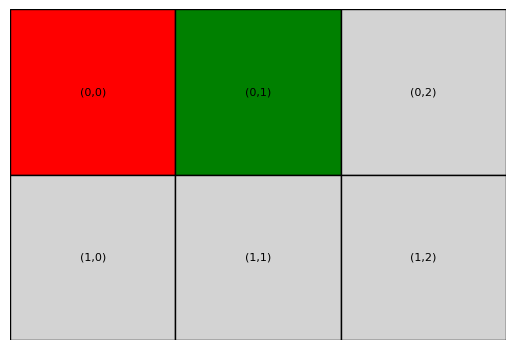

In [33]:
import numpy as np
import matplotlib.pyplot as plt


# Burned vertices (where prob == max_prob)
burned = {(i, j) for (i, j) in V if P[i, j] == max_prob}

# Defended vertices (where d_(i,j) == 1.0)
defended = {k for k, v in d_values.items() if abs(v - 1.0) < 1e-6}
print(defended)

# Now plot the grid
fig, ax = plt.subplots()
for (i, j) in V:
    if (i, j) in burned:
        color = "red"
    elif (i, j) in defended:
        color = "green"
    else:
        color = "lightgray"
    
    rect = plt.Rectangle((j, rows - 1 - i), 1, 1, facecolor=color, edgecolor="black")
    ax.add_patch(rect)
    ax.text(j + 0.5, rows - 1 - i + 0.5, f"({i},{j})", ha="center", va="center", fontsize=8)

ax.set_xlim(0, columns)
ax.set_ylim(0, rows)
ax.set_aspect("equal")
ax.axis("off")
plt.show()


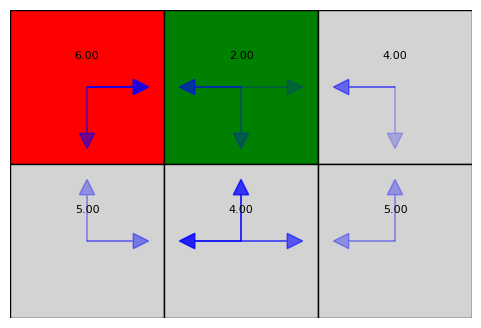

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming burned, defended, V, rows, columns, P, M are already defined

fig, ax = plt.subplots(figsize=(columns*2, rows*2))

for (i, j) in V:
    # Color based on burned / defended / neutral
    if (i, j) in burned:
        color = "red"
    elif (i, j) in defended:
        color = "green"
    else:
        color = "lightgray"
    
    # Draw cell
    rect = plt.Rectangle((j, rows - 1 - i), 1, 1, facecolor=color, edgecolor="black")
    ax.add_patch(rect)
    
    # Add probability of being burned inside the cell
    ax.text(j + 0.5, rows - 1 - i + 0.7, f"{P[i, j]:.2f}", ha="center", va="center", fontsize=8, color="black")

    # Show influence probabilities to adjacent cells (M)
    for (k, l) in V:
        if M[i, j, k, l] > 0 and abs(i - k) + abs(j - l) == 1:  # only adjacent
            dx = l - j
            dy = -(k - i)  # negative because plot y goes down
            ax.arrow(j + 0.5, rows - 1 - i + 0.5, 0.3*dx, 0.3*dy,
                     head_width=0.1, head_length=0.1, fc='blue', ec='blue', alpha=M[i,j,k,l])

ax.set_xlim(0, columns)
ax.set_ylim(0, rows)
ax.set_aspect("equal")
ax.axis("off")
plt.show()


# Optimización clásica

In [89]:
from ortools.linear_solver import pywraplp
import numpy as np

# Define graph: 2x2 grid
rows = 15
columns = 12
W = 17
max_prob = 6
delta = 1
V = [(i, j) for i in range(rows) for j in range(columns)]

def neighbors(x):
    i, j = x
    return [(ni, nj) for (ni, nj) in V if abs(ni - i) + abs(nj - j) == 1]

T = 1


# Parameters
max_prob_M = 0.7    # maximum probability for adjacent nodes
min_prob_M = 0.01   # minimum probability for far nodes
decay = 1.0       # how fast probability decays with distance

# Create meshgrid of coordinates
coords = np.array([[i, j] for i in range(rows) for j in range(columns)])

# Initialize M
M = np.zeros((rows, columns, rows, columns))

for i in range(rows):
    for j in range(columns):
        for k in range(rows):
            for l in range(columns):
                dist = np.sqrt((i - k)**2 + (j - l)**2)  # Euclidean distance
                prob = max_prob * np.exp(-decay * (dist) )  # decay with distance
                prob = np.clip(prob, min_prob_M, max_prob_M) # ensure in [min_prob, max_prob]
                M[i, j, k, l] = prob

# M = np.random.rand(rows, columns, rows, columns)
# Create arrays of indices
I, J = np.meshgrid(np.arange(rows), np.arange(columns), indexing='ij')

# Set the diagonal entries to 1
M[I, J, I, J] = 1.0


P_new = np.zeros((rows, columns))
S_0 = [(4, 2), (4, 3), (5, 3)]
for i in range(rows):
    for j in range(columns):
        prod = 1.0
        for (k, l) in S_0:
            prod *= 1 - M[k, l, i, j]   # multiply (1 - probability from burning node)
        P_new[i, j] = 1 - prod

# Scale and convert to integers
P_risk = np.round(P_new * max_prob).astype(int)

# Optional: clip in case of rounding issues
P_risk = np.clip(P_risk, 0, max_prob)

P = P_risk
E_t = np.sum(P/max_prob)


# Pair each vertex with its probability
pairs = [(x, P[x[0], x[1]]) for x in V]

# Sort by probability descending
pairs_sorted = sorted(pairs, key=lambda y: y[1], reverse=True)

# Take the top E_t + 1 vertices
S = [x for x, prob in pairs_sorted[:int(E_t) + 1]]
S = set(n for v in S_0 for n in neighbors(v))

# Convert S to a set for fast membership checks
S_set = set(S)

n, m, _, _ = M.shape

# Build boolean masks for the grid
mask_S = np.zeros((n, m), dtype=bool)
for (i, j) in S_set:
    mask_S[i, j] = True

# Expand masks to align with M
mask_ij = mask_S[:, :, None, None]         # True if (i,j) in S
mask_kl = ~mask_S[None, None, :, :]        # True if (k,l) not in S

# Apply masks
Q = M * mask_ij * mask_kl

# ============================================
# OR-Tools Model (handles quadratic problems)
# ============================================

# Create solver (using SCIP which handles quadratic problems)
solver = pywraplp.Solver.CreateSolver('SCIP')

if not solver:
    print("SCIP solver not available. Trying CBC...")
    solver = pywraplp.Solver.CreateSolver('CBC')

# Create binary decision variables
d = {x: solver.BoolVar(f"d_{x}") for x in V}

# Objective function: minimize sum of Q[i,j,k,l] * (1 - d[i,j]) * (1 - d[k,l])
# Expand: (1 - d[i,j]) * (1 - d[k,l]) = 1 - d[i,j] - d[k,l] + d[i,j]*d[k,l]
# We need to linearize the quadratic term d[i,j]*d[k,l]

# For binary variables, d[i,j]*d[k,l] can be linearized using a new variable
# Create auxiliary variables for products
y = {}
for (i, j) in V:
    for (k, l) in V:
        if Q[i, j, k, l] != 0:  # Only create vars where needed
            y[(i, j, k, l)] = solver.BoolVar(f"y_{i}_{j}_{k}_{l}")
            # y = d[i,j] * d[k,l] is enforced by:
            solver.Add(y[(i, j, k, l)] <= d[(i, j)])
            solver.Add(y[(i, j, k, l)] <= d[(k, l)])
            solver.Add(y[(i, j, k, l)] >= d[(i, j)] + d[(k, l)] - 1)

# Build objective: sum of Q[i,j,k,l] * (1 - d[i,j] - d[k,l] + y[i,j,k,l])
objective = solver.Objective()
for (i, j) in V:
    for (k, l) in V:
        coef = float(Q[i, j, k, l])
        if coef != 0:
            objective.SetCoefficient(d[(i, j)], objective.GetCoefficient(d[(i, j)]) - coef)
            objective.SetCoefficient(d[(k, l)], objective.GetCoefficient(d[(k, l)]) - coef)
            objective.SetCoefficient(y[(i, j, k, l)], coef)
            objective.SetOffset(objective.offset() + coef)

objective.SetMinimization()

# Constraint: sum of d variables <= W
constraint1 = solver.Constraint(-solver.infinity(), W, "capacity_constraint")
for (i, j) in V:
    constraint1.SetCoefficient(d[(i, j)], 1)

# Constraint: d[(i,j)] * P[i,j] <= max_prob - delta for each vertex
for (i, j) in V:
    constraint = solver.Constraint(-solver.infinity(), max_prob - delta, f"prob_constraint_{i}_{j}")
    constraint.SetCoefficient(d[(i, j)], float(P[i, j]))

# Solve
print("Solving with OR-Tools...")
status = solver.Solve()

# Print results
print("\n" + "="*50)
print("SOLUTION RESULTS")
print("="*50)

if status == pywraplp.Solver.OPTIMAL:
    print(f"Status: OPTIMAL")
    print(f"Optimal Objective Value: {solver.Objective().Value()}")
    
    # Create dictionary with all nodes and their values
    solution_dict = {x: d[x].solution_value() for x in V}
    
    print("\nDecision Variables (non-zero):")
    for x in V:
        if d[x].solution_value() > 0.5:
            print(f"  d{x} = {d[x].solution_value()}")
    
    print("\n" + "="*50)
    print("COMPLETE SOLUTION DICTIONARY")
    print("="*50)
    print("solution_dict = {")
    for x in V:
        print(f"    {x}: {solution_dict[x]},")
    print("}")
elif status == pywraplp.Solver.FEASIBLE:
    print(f"Status: FEASIBLE (not proven optimal)")
    print(f"Objective Value: {solver.Objective().Value()}")
    print("\nDecision Variables:")
    for x in V:
        if d[x].solution_value() > 0.5:
            print(f"  d{x} = {d[x].solution_value()}")
else:
    print(f"Status: {status}")
    print("No solution found")

print("\n" + "="*50)
print(f"Problem has {len(V)} vertices")
print(f"Number of binary variables: {len(d)}")
print(f"Number of auxiliary variables: {len(y)}")
print(f"Time: {solver.WallTime()} ms")
print("="*50)

Solving with OR-Tools...

SOLUTION RESULTS
Status: OPTIMAL
Optimal Objective Value: 107.37458118059563

Decision Variables (non-zero):
  d(1, 2) = 1.0
  d(1, 3) = 1.0
  d(2, 1) = 1.0
  d(2, 4) = 1.0
  d(2, 5) = 1.0
  d(3, 0) = 1.0
  d(3, 5) = 1.0
  d(4, 0) = 1.0
  d(4, 6) = 1.0
  d(5, 0) = 1.0
  d(5, 6) = 1.0
  d(6, 0) = 1.0
  d(6, 5) = 1.0
  d(7, 1) = 1.0
  d(7, 2) = 1.0
  d(7, 3) = 1.0
  d(7, 4) = 1.0

COMPLETE SOLUTION DICTIONARY
solution_dict = {
    (0, 0): 0.0,
    (0, 1): 0.0,
    (0, 2): 0.0,
    (0, 3): 0.0,
    (0, 4): 0.0,
    (0, 5): 0.0,
    (0, 6): 0.0,
    (0, 7): 0.0,
    (0, 8): 0.0,
    (0, 9): 0.0,
    (0, 10): 0.0,
    (0, 11): 0.0,
    (1, 0): 0.0,
    (1, 1): 0.0,
    (1, 2): 1.0,
    (1, 3): 1.0,
    (1, 4): 0.0,
    (1, 5): 0.0,
    (1, 6): 0.0,
    (1, 7): 0.0,
    (1, 8): 0.0,
    (1, 9): 0.0,
    (1, 10): 0.0,
    (1, 11): 0.0,
    (2, 0): 0.0,
    (2, 1): 1.0,
    (2, 2): 0.0,
    (2, 3): 0.0,
    (2, 4): 1.0,
    (2, 5): 1.0,
    (2, 6): 0.0,
    (2, 7): 0.

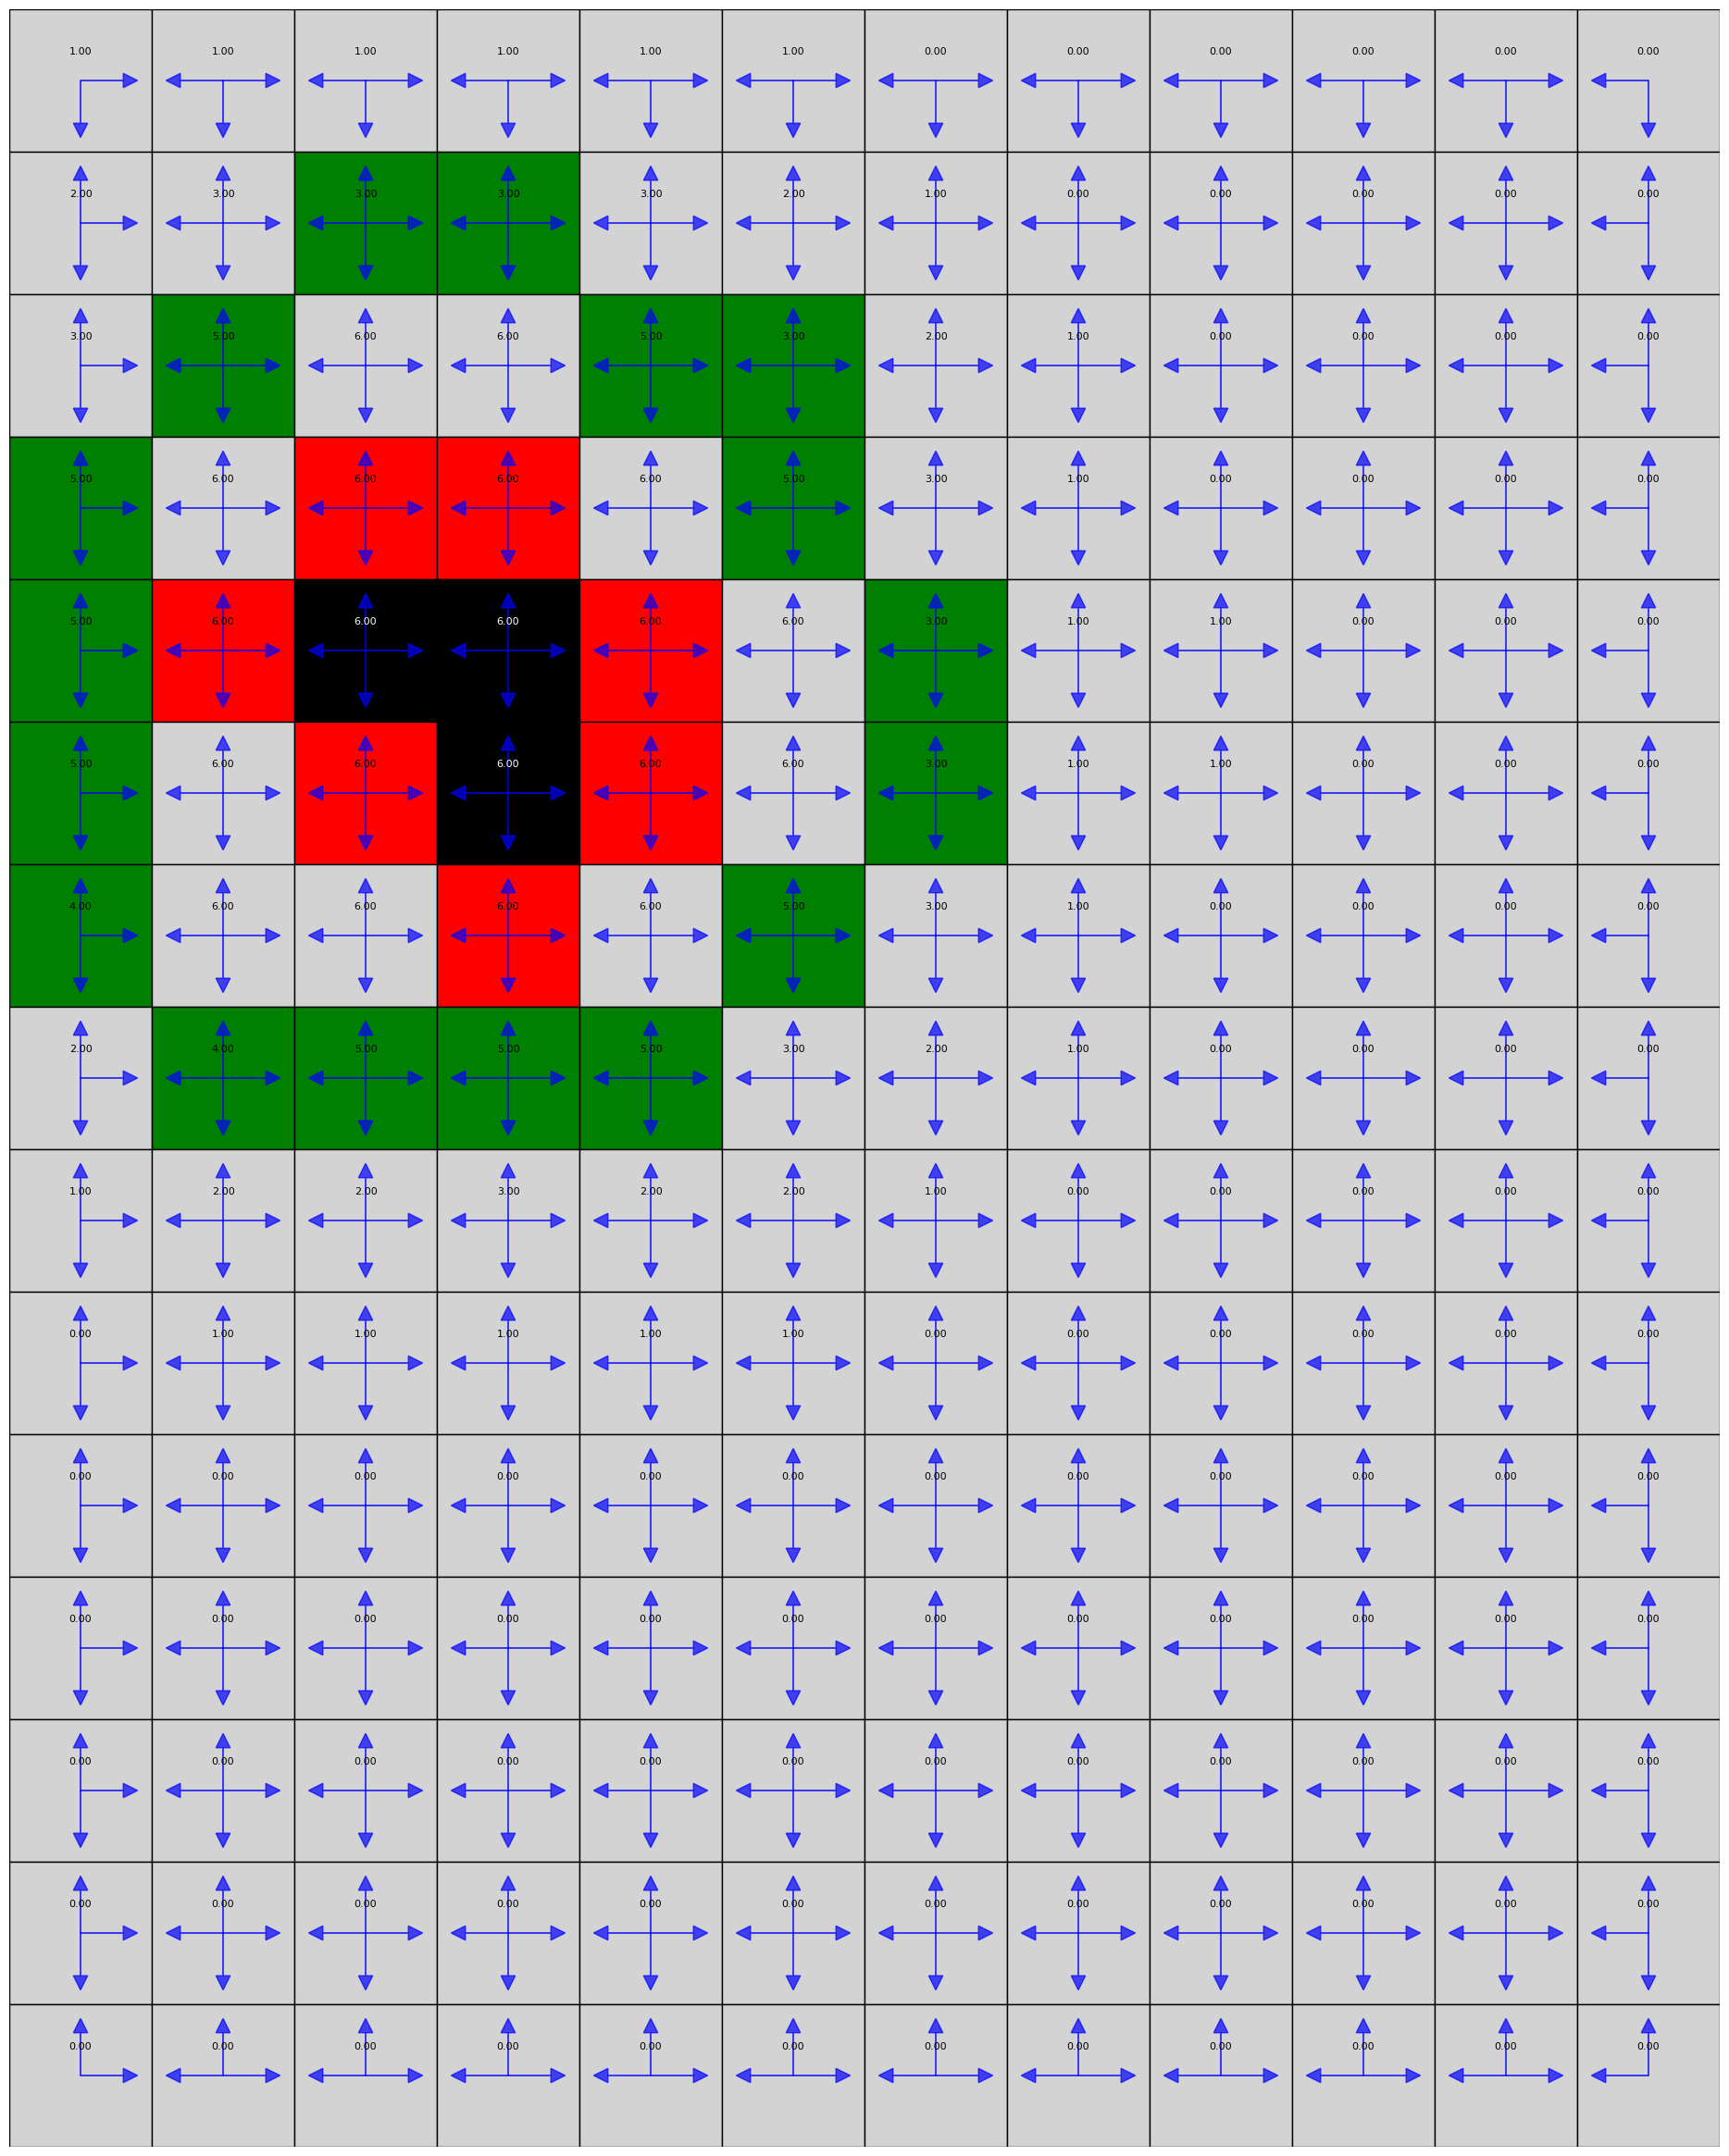

In [90]:
# Assuming S_0, S, solution_dict, V, rows, columns, P, M are already defined

fig, ax = plt.subplots(figsize=(columns*2, rows*2))

# Defended nodes
defended = {k for k, v in solution_dict.items() if abs(v - 1.0) < 1e-6}

# Burned nodes are S minus defended nodes and minus initial burning nodes
burned = S - defended - set(S_0)

for (i, j) in V:
    # Color based on category
    if (i, j) in S_0:
        color = "black"
    elif (i, j) in burned:
        color = "red"
    elif (i, j) in defended:
        color = "green"
    else:
        color = "lightgray"
    
    # Draw cell
    rect = plt.Rectangle((j, rows - 1 - i), 1, 1, facecolor=color, edgecolor="black")
    ax.add_patch(rect)
    
    # Optional: add probability inside the cell
    ax.text(j + 0.5, rows - 1 - i + 0.7, f"{P[i, j]:.2f}", ha="center", va="center", fontsize=8, color="white" if color=="black" else "black")

    # Show influence probabilities to adjacent cells (M)
    for (k, l) in V:
        if M[i, j, k, l] > 0 and abs(i - k) + abs(j - l) == 1:  # only adjacent
            dx = l - j
            dy = -(k - i)  # negative because plot y goes down
            ax.arrow(j + 0.5, rows - 1 - i + 0.5, 0.3*dx, 0.3*dy,
                     head_width=0.1, head_length=0.1, fc='blue', ec='blue', alpha=M[i,j,k,l])

ax.set_xlim(0, columns)
ax.set_ylim(0, rows)
ax.set_aspect("equal")
ax.axis("off")
plt.show()


# Grover solution: 

In [7]:
# Define graph: 2x2 grid
rows = 1
columns = 2
W = 1
max_prob = 6
delta = 1
V = [(i, j) for i in range(rows) for j in range(columns)]

def neighbors(x):
    i, j = x
    return [(ni, nj) for (ni, nj) in V if abs(ni - i) + abs(nj - j) == 1]

T = 1

M = np.random.rand(rows, columns, rows, columns)
P = np.random.randint(1, max_prob, size=(rows, columns))
P[0, 0] = max_prob
E_t = np.sum(P/max_prob)


# Pair each vertex with its probability
pairs = [(x, P[x[0], x[1]]) for x in V]

# Sort by probability descending
pairs_sorted = sorted(pairs, key=lambda y: y[1], reverse=True)

# Take the top E_t + 1 vertices
S = [x for x, prob in pairs_sorted[:int(E_t) + 1]]


# Convert S to a set for fast membership checks
S_set = set(S)

n, m, _, _ = M.shape

# Build boolean masks for the grid
mask_S = np.zeros((n, m), dtype=bool)
for (i, j) in S_set:
    mask_S[i, j] = True

# Expand masks to align with M
mask_ij = mask_S[:, :, None, None]         # True if (i,j) in S
mask_kl = ~mask_S[None, None, :, :]        # True if (k,l) not in S

# Apply masks
Q = M * mask_ij * mask_kl


# Model
model = Model()

d = {x: model.binary_var(name=f"d_{x}") for x in V}

model.minimize(
    model.sum(
        Q[i, j, k, l] * (1 - d[(i, j)]) * (1 - d[(k, l)])
        for (i, j) in V
        for (k, l) in V
    )
)

model.add_constraint(sum(d[(i, j)] for (i, j) in V) <= W)

for (i, j) in V:
    model.add_constraint(d[(i, j)]*P[i, j] <= max_prob - delta)




qp = from_docplex_mp(model)
print(qp.prettyprint())

Problem name: docplex_model2

Minimize
  0

Subject to
  Linear constraints (3)
    d_(0, 0) + d_(0, 1) <= 1  'c0'
    6*d_(0, 0) <= 5  'c1'
    d_(0, 1) <= 5  'c2'

  Binary variables (2)
    d_(0, 0) d_(0, 1)



In [ ]:
from QUBO_grover import *

grover_optimizer = GroverOptimizer(4, num_iterations=10, sampler=StatevectorSampler(seed=123))
results = grover_optimizer.solve(qp)
print(results.prettyprint())